# Artificial Intelligence Challenge by Randstad

### Lorenzo Nicoletti

This is my proposed implementation for the AI Challenge. It exploits the [PyTorch](https://pytorch.org/) framework and, in particular, the [PyTorch Lightning](https://www.pytorchlightning.ai/) library. The model is the italian adaptation of the [BERT](https://arxiv.org/abs/1810.04805) transformer from [HuggingFace](https://huggingface.co/) to extract contextualized information about sentences (i.e., the job offers).

This notebook has been fully created on [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb). Please, upload the dataset and the model weights in the correct location.

## Preliminaries

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Environmental setup

We first restyle our environment by downloading the given datasets and some required libraries.

In [2]:
! rm -rf sample_data
! cp "/content/drive/MyDrive/Colab Notebooks/Randstad_Artificial_intelligence_Challenge/Dataset_Randstad-Challenge.zip" /content/
! unzip -q Dataset_Randstad-Challenge.zip
! mkdir data
! mv train_set.csv data/
! mv test_set.csv data/
! rm Dataset_Randstad-Challenge.zip

In [3]:
! pip install transformers
! pip install pytorch-lightning

     |████████████████████████████████| 2.8 MB 4.9 MB/s 
     |████████████████████████████████| 895 kB 52.3 MB/s 
     |████████████████████████████████| 3.3 MB 38.4 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 636 kB 48.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 919 kB 5.1 MB/s 
     |████████████████████████████████| 829 kB 32.8 MB/s 
     |████████████████████████████████| 282 kB 62.5 MB/s 
     |████████████████████████████████| 119 kB 70.9 MB/s 
     |████████████████████████████████| 1.3 MB 40.4 MB/s 
     |████████████████████████████████| 294 kB 62.5 MB/s 
     |████████████████████████████████| 142 kB 62.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=8ac4cec38beb5add5a2014e07f04d5e5cc5fcf2b289e8e5eb12b09643696f181
  Store

### Library imports

In [4]:
import numpy as np
import torch
import torchmetrics
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, AdamW
import pytorch_lightning as pl
import csv
from tqdm.notebook import tqdm_notebook
from typing import Optional, List, Dict, Union, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report

We can set a seed to guarantee the repeatabaility of the experiments if needed.

In [ ]:
# to guarantee repetability of the experiments if needed
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# device on which we will store everything
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Experiments will run on', DEVICE)

# mapping from word labels to number labels
mapping = {'Java Developer': 0,
           'Web Developer': 1,
           'Programmer': 2,
           'System Analyst': 3,
           'Software Engineer': 4}

Experiments will run on cuda


## Data Preprocessing

Our datasets are stored in *csv* files where each line is composed by the job offer sentence and the label divided by a ",".

In [7]:
# function to read the csv dataset and create a list where each entry is
# a dictionary with <job offer, label> pairs
def csv2list(path) -> List[Dict]:
    with open(path) as f:
        # skip header
        next(f)
        reader = csv.reader(f, delimiter=',')

        dataset = []
        for row in reader:
            # read dataset line by line
            data_item = {'job_offer': row[0]}
            data_item['label'] = row[1]

            dataset.append(data_item)
      
    return dataset

train_data = csv2list('data/train_set.csv')
test_data = csv2list('data/test_set.csv')

### Dataset and DataLoader

Now we need to process data in order to convert them in the correct BERT format, namely with three elements:
* **input_ids:** indices of the words such that each word/token has its own unique index;
* **attention_mask:** to distinguish between real data and padding;
* **token_type_ids:** to distinguish between words/tokens of different sentences (in this case, they are not strictly required because we have one single sentence).

```BertTokenizer``` is the main element of this preprocessing, it is a tokenizer and a converter that builds the input for BERT models.

Since we have senteces in Italian language, we must keep in mind to adopt the ```bert-base-italian-cased``` version of the traditional English ```bert-base-cased```.


We create Pytorch ```Dataset``` instances to contain everything we need.

In [ ]:
class RandstadDataset(Dataset):

    def __init__(self,
                data: list,
                device: str):
      
        self.samples = []
        self.data = data
        
        self.device = device

        self.tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-italian-cased',
                                                      do_lower_case=True)

        self.init_data()

    def init_data(self):

        for elem in self.data:
            # mapping the label
            label = torch.tensor(mapping[elem['label']])

            # the tokenizer derives the tokens ...
            tokens = self.tokenizer.tokenize(elem['job_offer'])

            # ... and encodes them to get the input_ids, attention_mask and token_type_ids
            encoding = self.tokenizer.encode_plus(tokens,
                                                  max_length=512,
                                                  truncation=True,
                                                  add_special_tokens=True,
                                                  return_attention_mask=True,
                                                  return_token_type_ids=True,
                                                  return_tensors='pt')
            
            self.samples.append([encoding['input_ids'].to(self.device),
                                encoding['attention_mask'].to(self.device),
                                encoding['token_type_ids'].to(self.device),
                                label])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [ ]:
# a batch must be composed by elements of the same size -> this collate function
# realizes this goal by padding to the maximum size of the longest element in each batch
def collate_fn(data_elements: List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]
               ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

    input_ids = [de[0].squeeze(0) for de in data_elements]
    attention_masks = [de[1].squeeze(0) for de in data_elements]
    token_type_ids = [de[2].squeeze(0) for de in data_elements]
    labels = [de[3] for de in data_elements]
    
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks = torch.nn.utils.rnn.pad_sequence(attention_masks, batch_first=True, padding_value=0)
    token_type_ids = torch.nn.utils.rnn.pad_sequence(token_type_ids, batch_first=True, padding_value=0)

    return input_ids, attention_masks, token_type_ids, torch.tensor(labels).to(DEVICE)


Finally, the Pytorch ```LightningDataModule``` is created to collect the two datasets (train and test sets) and the associated ```DataLoader```s with the collate function above.

In [ ]:
class RandstadDataModule(pl.LightningDataModule):

    def __init__(self,
                train_data_path: str,
                test_data_path: str,
                batch_size: int):
      
        super().__init__()

        self.train_data_path = train_data_path
        self.test_data_path = test_data_path
        
        self.batch_size = batch_size

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    # setup function to instantiate the datasets
    def setup(self, stage: Optional[str] = None) -> None:
        if stage == 'fit':
            self.train_dataset = RandstadDataset(self.train_data_path, DEVICE)
            self.val_dataset = RandstadDataset(self.test_data_path, DEVICE)
        elif stage == 'test':
            self.test_dataset = RandstadDataset(self.test_data_path, DEVICE)

    # create train dataloader
    def train_dataloader(self, *args, **kwargs) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=collate_fn)

    def val_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=collate_fn)

    # create test dataloader
    def test_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(self.test_dataset, batch_size=self.batch_size, collate_fn=collate_fn)

In [ ]:
dm = RandstadDataModule(train_data, test_data, batch_size=8)

In [ ]:
# check if you want

dm.setup('test')

dl = dm.test_dataloader()

for batches in dl:
    input_ids, attention_masks, token_type_ids, labels = batches
    print('length of the batches:', len(batches))
    print(input_ids)
    print(attention_masks)
    print(token_type_ids)
    print(labels)
    print(input_ids.shape)
    print(attention_masks.shape)
    print(token_type_ids.shape)
    print(labels.shape)
    break


length of the batches: 4
tensor([[  102,  1152,   334,  ...,     0,     0,     0],
        [  102,   639,  1553,  ...,     0,     0,     0],
        [  102,  2486,  2440,  ...,     0,     0,     0],
        ...,
        [  102,  2486,  5407,  ...,     0,     0,     0],
        [  102, 24450,   827,  ...,   769,   194,   103],
        [  102,   700,   141,  ...,     0,     0,     0]], device='cuda:0')
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor([1, 0, 3, 3, 0, 0, 0, 1], device='cuda:0')
torch.Size([8, 205])
torch.Size([8, 205])
torch.Size([8, 205])
torch.Size([8

## Experiments

### Model definition

According to the BERT literature, a BERT model can be easily fine-tuned by using a ```BertPreTrainedModel``` instance that contains the ```BertModel``` followed by a Linear layer to perform classification.

This instance will be the main element in the standard `pl.LightningModule` just below.

In [ ]:
class MyBERT(BertPreTrainedModel):
  
    def __init__(self, config):
        super().__init__(config)

        # we basically have BERT + dropout + Linear layer for classification
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        # the linear layer has (768=hidden size of BERT x 5=num classes) dimension
        self.output = torch.nn.Linear(config.hidden_size, 5)

        self.init_weights()
    
    def forward(self, input_ids, attention_mask, token_type_ids):
      
        # flow of information through the layers of the network
        bert_output = self.bert(input_ids, attention_mask, token_type_ids)
        dropout_output = self.dropout(bert_output[1])
        logits = self.output(dropout_output).squeeze(-1)

        return logits

class RandstadModel(pl.LightningModule):

    def __init__(self, config):
        super().__init__()

        self.tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-italian-cased',
                                                      do_lower_case=True)

        # transformers fine-tuning 'black magic': with one line of code we can fine-tune the model
        self.bert = MyBERT.from_pretrained('dbmdz/bert-base-italian-cased', config=config)

        # metrics to monitor and test the model
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.val_f1 = torchmetrics.F1(5)
        self.test_f1 = torchmetrics.F1(5)

        self.save_hyperparameters()

    def forward(self, input_ids, attention_mask, token_type_ids, labels: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:

        logits = self.bert(input_ids, attention_mask, token_type_ids)
        # we get a probability distribution (the highest logits corresponds to the
        # most likely label)
        pred = torch.softmax(logits, dim=-1)

        result = {'logits': logits, 'pred': pred}

        # compute loss
        if labels is not None:
            loss = self.loss(logits, labels)
            result['loss'] = loss

        return result
    
    def training_step(
        self, 
        batch: Tuple[torch.Tensor], 
        batch_idx: int
    ) -> torch.Tensor:

        # single training step: we take the output of the model and monitor loss and F1
        forward_output = self.forward(*batch)
        self.log('train_loss', forward_output['loss'], prog_bar=True)
        self.test_f1(forward_output['pred'], batch[3])
        self.log('train_f1', self.test_f1, prog_bar=True)
        return forward_output

    def validation_step(
        self, 
        batch: Tuple[torch.Tensor], 
        batch_idx: int
    ) -> torch.Tensor:

        # single validation step: we take the output of the model and monitor loss and F1
        forward_output = self.forward(*batch)
        self.log('val_loss', forward_output['loss'], prog_bar=True)
        self.val_f1(forward_output['pred'], batch[3])
        self.log('val_f1', self.val_f1, prog_bar=True)
        return forward_output

    def test_step(
        self,
        batch: Tuple[torch.Tensor],
        batch_idx: int
    ):
        # single testing step: we take the output of the model and test the F1
        forward_output = self.forward(*batch)
        self.test_f1(forward_output['pred'], batch[3])
        self.log('test_f1', self.test_f1, prog_bar=True)

    def loss(self, pred, y):
        return self.loss_fn(pred, y)

    def configure_optimizers(self):
      
        # standard initialization of the AdamW optimizer according to the
        # transformers literature
        param_optimizer = list(self.bert.named_parameters())
        no_decay = ["bias", "gamma", "beta"]
        optimizer_grouped_parameters = [
                {
                    "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                    "weight_decay_rate": 0.01
                    },
                {
                    "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                    "weight_decay_rate": 0.0
                    },
                ]
        optimizer = AdamW(
                optimizer_grouped_parameters,
                lr=2e-5,
                eps=1e-8
                )
        return optimizer

    # in the predict function we take as input a job offer and we output the most
    # likely label according to our network
    def predict(self, sentence: str) -> str:

        # we proceed again with the tokenization and the encoding as done in the preprocessing
        tokens = self.tokenizer.tokenize(sentence)

        encoding = self.tokenizer.encode_plus(tokens,
                                              max_length=512,
                                              truncation=True,
                                              add_special_tokens=True,
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              return_tensors='pt')
        
        # doing inference
        with torch.no_grad():
            pred = self(encoding['input_ids'].to(self.device),
                        encoding['attention_mask'].to(self.device),
                        encoding['token_type_ids'].to(self.device))['pred']
            
        # we output only the mapped label
        # the index of max value correspond to the class
        pred = torch.max(pred, -1).indices
        for key, value in mapping.items():
            if value == pred:
                label = key
        return label 


The model is finally created by specifying a ```BertConfig``` class (in particular, $num \ labels = 5 = |\{0, 1, 2, 3, 4\}|$ ) to be passed to the ```BertPreTrainedModel``` model.

In [ ]:
# bert configuration with 5 classes, dropout of 0.1 and 768 as defualt hidden size
config = BertConfig.from_pretrained('dbmdz/bert-base-italian-cased',
                                    num_labels=5,
                                    hidden_dropout_prob=0.0,  # experiments have shown that no dropout leads to the best results
                                    hidden_size=768)

model = RandstadModel(config).to(DEVICE)

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing MyBERT: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing MyBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyBERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyBERT were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['output.bias', 'outpu

The training procedure is directly handled by Pytorch Lightning: we just neeed to create a ```pl.Trainer``` and define some callbacks if needed.

In [ ]:
# two callbacks:
# - early stopping to avoid overfitting
early_stopping = pl.callbacks.EarlyStopping(
    monitor='train_loss',  # the value that will be evaluated to activate the early stopping of the model.
    patience=3,  # the number of consecutive attempts that the model has to raise (or lower depending on the metric used) to raise the "monitor" value.
    verbose=True,  # whether to log or not information in the console.
    mode='min', # wheter we want to maximize (max) or minimize the "monitor" value.
)

# - best checkpoint saving to reach the highest results later
check_point_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_f1',  # the value that we want to use for model selection.
    verbose=True,  # whether to log or not information in the console.
    save_top_k=3,  # the number of checkpoints we want to store.
    mode='max',  # wheter we want to maximize (max) or minimize the "monitor" value.
    dirpath='/content/drive/MyDrive/Colab Notebooks/Randstad_Artificial_intelligence_Challenge/ckpt/',  # output directory path
    filename='randstad_classifier'+'-{epoch}-{val_f1:.4f}'  # the prefix on the checkpoint values. Metrics store by the trainer can be used to dynamically change the name.
)

trainer = pl.Trainer(max_epochs=10,
                     gpus=1 if torch.cuda.is_available() else 0,
                     progress_bar_refresh_rate=50,
                     callbacks=[early_stopping, check_point_callback])


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab Notebooks/Randstad_Artificial_intelligence_Challenge/ckpt/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


### Training

In [ ]:
trainer.fit(model=model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | bert    | MyBERT           | 109 M 
1 | loss_fn | CrossEntropyLoss | 0     
2 | val_f1  | F1               | 0     
3 | test_f1 | F1               | 0     
---------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
439.726   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:398: LightningDeprecationWarning: One of the returned values {'logits', 'pred'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.920
Epoch 0, global step 218: val_f1 reached 0.69704 (best 0.69704), saving model to "/content/drive/MyDrive/Colab Notebooks/Randstad_Artificial_intelligence_Challenge/ckpt/randstad_classifier-epoch=0-val_f1=0.6970.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.599 >= min_delta = 0.0. New best score: 0.321
Epoch 1, global step 437: val_f1 reached 0.80182 (best 0.80182), saving model to "/content/drive/MyDrive/Colab Notebooks/Randstad_Artificial_intelligence_Challenge/ckpt/randstad_classifier-epoch=1-val_f1=0.8018.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.280 >= min_delta = 0.0. New best score: 0.041
Epoch 2, global step 656: val_f1 reached 0.81093 (best 0.81093), saving model to "/content/drive/MyDrive/Colab Notebooks/Randstad_Artificial_intelligence_Challenge/ckpt/randstad_classifier-epoch=2-val_f1=0.8109.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 875: val_f1 reached 0.81093 (best 0.81093), saving model to "/content/drive/MyDrive/Colab Notebooks/Randstad_Artificial_intelligence_Challenge/ckpt/randstad_classifier-epoch=3-val_f1=0.8109.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.027
Epoch 4, global step 1094: val_f1 reached 0.84510 (best 0.84510), saving model to "/content/drive/MyDrive/Colab Notebooks/Randstad_Artificial_intelligence_Challenge/ckpt/randstad_classifier-epoch=4-val_f1=0.8451.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 1313: val_f1 reached 0.83827 (best 0.84510), saving model to "/content/drive/MyDrive/Colab Notebooks/Randstad_Artificial_intelligence_Challenge/ckpt/randstad_classifier-epoch=5-val_f1=0.8383.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 1532: val_f1 was not in top 3


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.013
Epoch 7, global step 1751: val_f1 reached 0.81549 (best 0.84510), saving model to "/content/drive/MyDrive/Colab Notebooks/Randstad_Artificial_intelligence_Challenge/ckpt/randstad_classifier-epoch=7-val_f1=0.8155.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.008
Epoch 8, global step 1970: val_f1 reached 0.81777 (best 0.84510), saving model to "/content/drive/MyDrive/Colab Notebooks/Randstad_Artificial_intelligence_Challenge/ckpt/randstad_classifier-epoch=8-val_f1=0.8178.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.004
Epoch 9, global step 2189: val_f1 reached 0.84738 (best 0.84738), saving model to "/content/drive/MyDrive/Colab Notebooks/Randstad_Artificial_intelligence_Challenge/ckpt/randstad_classifier-epoch=9-val_f1=0.8474.ckpt" as top 3


### Evaluation and results

We first evaluate on the test set using Pytorch Lightning again and compute the corresponding F1 score.

In [ ]:
# load the best model
model = RandstadModel.load_from_checkpoint('/content/drive/MyDrive/Colab Notebooks/Randstad_Artificial_intelligence_Challenge/ckpt/bert-base-italian-cased-epoch=9-val_f1=0.8474.ckpt')

trainer.test(model=model, datamodule=dm)

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing MyBERT: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing MyBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyBERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyBERT were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['output.bias', 'outpu

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_f1': 0.8473803997039795}
--------------------------------------------------------------------------------


[{'test_f1': 0.8473803997039795}]

Now, we proceed with a deeper analysis on our results by deriving Precision and Recall too with respect to each class and to the average.

In [ ]:
# load the best model
model = RandstadModel.load_from_checkpoint('/content/drive/MyDrive/Colab Notebooks/Randstad_Artificial_intelligence_Challenge/ckpt/bert-base-italian-cased-epoch=9-val_f1=0.8474.ckpt')
# set to eval() for inference
model.eval()
model.to(DEVICE)

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing MyBERT: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing MyBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyBERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyBERT were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['output.bias', 'outpu

RandstadModel(
  (bert): MyBERT(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(31102, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (Laye

In [ ]:
gold_labels = [elem['label'] for elem in test_data]

# collect the predictions by analysing every single sentence
predictions = []
for elem in tqdm_notebook(test_data):
    predictions.append(model.predict(elem['job_offer']))


  0%|          | 0/439 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

   Java Developer     0.8132    0.8132    0.8132        91
    Web Developer     0.8900    0.8641    0.8768       103
       Programmer     0.7524    0.8229    0.7861        96
   System Analyst     0.9444    0.9189    0.9315        74
Software Engineer     0.8732    0.8267    0.8493        75

         accuracy                         0.8474       439
        macro avg     0.8547    0.8492    0.8514       439
     weighted avg     0.8503    0.8474    0.8483       439

# precision: 0.8547
# recall: 0.8492
# acc: 0.8474
# f1: 0.8514


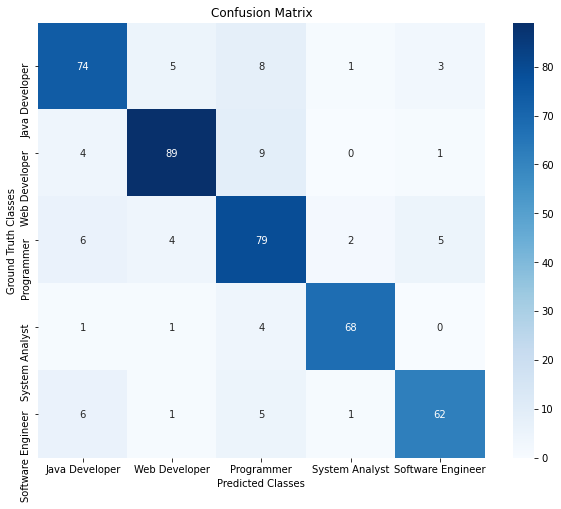

In [ ]:
# evaluating function that computes precision, recall, F1 and accuracy of the model
# and plots the confusion matrix and the related classification report
def evaluate_results(labels, predictions):

    cm = confusion_matrix(labels, predictions, labels=list(mapping.keys()))
    plt.figure(figsize=(10,8))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='d')

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Classes')
    ax.set_ylabel('Ground Truth Classes')
    ax.xaxis.set_ticklabels(list(mapping.keys()))
    ax.yaxis.set_ticklabels(list(mapping.keys()))

    print(classification_report(labels, predictions, labels=list(mapping.keys()), digits=4))

    p = precision_score(labels, predictions, average='macro')
    r = recall_score(labels, predictions, average='macro')
    a = accuracy_score(labels, predictions)
    f = f1_score(labels, predictions, average='macro')

    print(f'# precision: {p:.4f}')
    print(f'# recall: {r:.4f}')
    print(f'# acc: {a:.4f}')
    print(f'# f1: {f:.4f}')

evaluate_results(gold_labels, predictions)